In [1]:
## custom
import utils, vis
import criteria as C


## third party
import networkx as nx
import poly_point_isect as bo   ##bentley-ottmann sweep line

from PIL import Image
from natsort import natsorted


## sys
import random
import time
from glob import glob
import math

## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from IPython.display import clear_output
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


In [2]:
def runtime2csv(runtime, fn='runtime.csv'):
    with open(fn, 'a') as f:
        for rt in runtime:
            line = ', '.join([str(i) for i in rt])
            f.write(line + '\n')


## Optimize via Stochastic Gradient Descent (SGD)

In [3]:
# delete old
# !rm -r fig
!mkdir fig

mkdir: fig: File exists


In [4]:
runtime = []

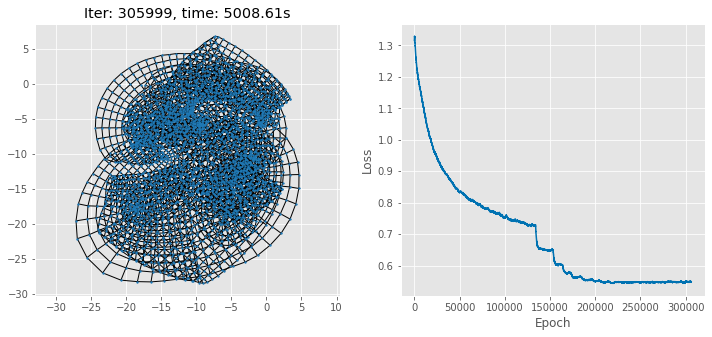

Epoch 306181: reducing learning rate of group 0 to 1.0000e-05.
Done


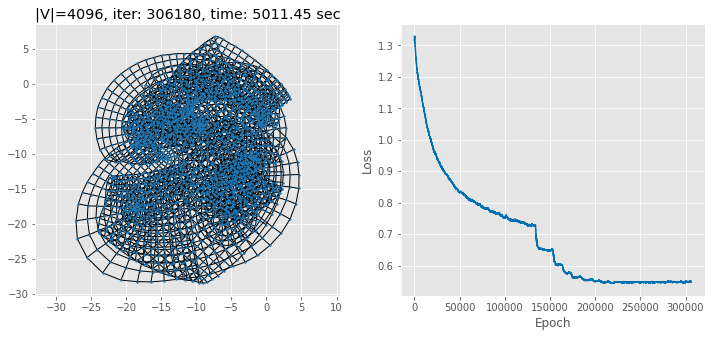

CPU times: user 2h 8min 44s, sys: 18min 29s, total: 2h 27min 14s
Wall time: 2h 11min 59s


In [28]:
%%time

niter = int(1e6)

shouldVis = True
visIter = 2000

shouldSnap = False
snapIter = 25

gClamp = 1000
minLR = 1e-5
# maxSampleSize = 128
maxSampleSize = 256

# for depth in range(3,11+1):## trees
# for depth in range(1,8+1):## grids
for depth in range(7,9):## grids
# for depth in [3,4,5,]:## debug
    
    totalTime = 0
    print('generating graph', end=' ')
    graphName, G = f'grid_2d_graph_16_{int(2**depth)}', nx.grid_2d_graph(16,int(2**depth))
#     graphName, G = f'balanced_tree_2_{depth}', nx.balanced_tree(2,depth)
    print(f'of {len(G)} nodes')

    print('Calculating all pairs shortest path', end='...')
    t0 = time.time()
    D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
    adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
    i2k = {i:k for k,i in k2i.items()}
    dt = time.time() - t0
    totalTime += dt

    W = 1/(D**2+np.eye(len(G)))
    truth = adj + torch.eye(adj.shape[0], device=device)
    print('done')

    ##training
    sampleSize = min(len(G), maxSampleSize)
    
#     pos = torch.rand(len(G.nodes), 2, device=device)*2-1
    pos = torch.randn(len(G.nodes), 2, device=device)
    pos.requires_grad_(True)

#     optimizer = optim.SGD([pos], lr=0.05, momentum=0.9, nesterov=True)
    optimizer = optim.RMSprop([pos], lr=0.1)
#     patience = np.ceil(np.log2(len(G)))*100
#     patience = max(100, int(len(G)/sampleSize)*100)##for trees
    patience = max(100, int(len(G)/sampleSize)*300)
#     scheduler = None
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=patience, 
#                                                      threshold = 0.001, threshold_mode='abs',
                                                     min_lr=minLR, verbose=True)
    
    iterBar = tqdm(range(niter))
    lossCurve = []
    degrees = adj.sum(1).numpy().astype(np.int64)
    xPath = []

    for i in iterBar:
        t0 = time.time()
        optimizer.zero_grad()
        
        criterionName = 'neighborhood_preseration'
#         loss = C.stress(pos, D, W, sampleSize)
        loss = C.neighborhood_preseration(pos, G, adj, k2i, i2k, n_roots=2, depth_limit=2)
#         loss = C.edge_uniformity(pos, G, k2i, sampleSize-1)
#         loss = C.aspect_ratio(pos, sampleSize)
#         loss = C.crossing_angle_maximization(pos, G, k2i, i2k, sampleSize=10) ## slow for large sample size
#         loss = C.vertex_resolution(pos, sampleSize, target=1/len(G)**0.5)
#         loss = 0.1*C.gabriel(pos, G, k2i, sampleSize=int(sampleSize**0.5))

    #     ## TODO: do the following efficiently and stochastically
#         loss += 1*C.crossings(pos, G, k2i, sampleSize=50)
    #     loss += 0.5 * C.angular_resolution(pos, G, k2i, sampleSize)## reyan's working on it
        
        loss.backward()
        pos.grad.clamp_(-gClamp, gClamp)
        optimizer.step()

        ##debug info
        dt = time.time() - t0
        totalTime += dt
        
        if i % int(niter/100) == int(niter/100)-1:
            iterBar.set_postfix({'loss': loss.item()})

        if len(lossCurve) > 0:
            lossCurve.append(0.999*lossCurve[-1] + 0.001*loss.item())
        else:
            lossCurve.append(loss.item())

        if scheduler is not None:
            scheduler.step(lossCurve[-1])

        if shouldSnap and i % snapIter == 0:
            x = pos.detach().cpu().numpy()
            xPath.append(x.copy())

        ##vis
        if shouldVis and i % visIter == visIter-1:
            x = pos.detach().cpu().numpy()
            pos_i = {k: x[k2i[k], :2] for k in G.nodes}
            display.clear_output(wait=True)
            vis.plot(G, pos_i, lossCurve, [], i, totalTime, edge=True, show=True, save=False)

        if optimizer.param_groups[0]['lr'] <= minLR:
            print('Done')
            break
    runtime.append([graphName, criterionName, len(G), i, totalTime])
    runtime2csv(runtime[-1:])
    
    
    ## show final result
    x = pos.detach().cpu().numpy()   
    pos_i = {k: x[k2i[k], :2] for k in G.nodes}
    ## save layouts
    for k in G.nodes:
        G.nodes[k]['pos'] = pos_i[k]
    nx.write_gpickle(G, f'layouts/{graphName}-{criterionName}-iter{i}.gpickle')
    
    vis.plot(G, pos_i, lossCurve, [], i, totalTime,  
             show=True, 
             save=True, saveName=f'fig/{graphName}-{criterionName}-iter{i}.png',
             title=f'|V|={len(G)}, iter: {i}, time: {totalTime:.2f} sec')
    
    

In [19]:
import importlib
vis = importlib.reload(vis)

1600

## read layouts

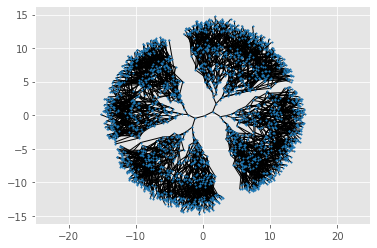

In [6]:
G = nx.read_gpickle('layouts/balanced_tree_2_10-stress-iter75811.gpickle')
pos = {i: G.nodes[i]['pos'] for i in G.nodes}
nx.draw_networkx(G, pos, node_size=2, with_labels=False)
plt.axis('equal')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## save runtime fig

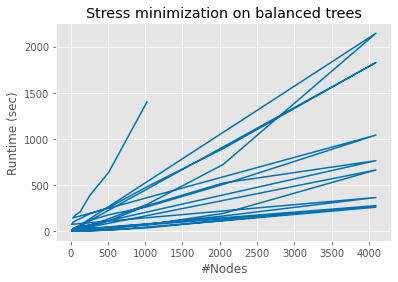

In [27]:
import pandas as pd

df = pd.read_csv(
    'runtime.csv', 
    names=['graph', 'criterion', 'nodeCount', 'iterCount', 'runtime']
)


x = df['nodeCount']
y = df['runtime']
plt.plot(x, y)

plt.xlabel('#Nodes')
plt.ylabel('Runtime (sec)')
plt.title('Stress minimization on balanced trees')

# plt.savefig(f'runtime.pdf')
plt.show()

## Animation

In [8]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# if type(xPath) == list:
#     xPath = np.stack(xPath)
    
# padding = 0.1

# fig, ax = plt.subplots()
# scatter = plt.scatter([0], [0], s=10)
# lc = mc.LineCollection([], linewidths=1)
# ax.add_collection(lc)

# xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
# ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
# xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
# ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
    
# def init():
#     return scatter,lc

# def update(frame):
#     xy = xPath[frame]
#     scatter.set_offsets(xy)
#     segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]           
#     lc.set_segments(segs)
#     return scatter,lc

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=range(0,len(xPath),1),
#     init_func=init, 
#     interval=1000.0/20,
#     blit=True)

# HTML(anim.to_jshtml())

In [9]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation from image files

In [10]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)